## Face Mask Detection using CNN
- https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

### Unzip data

In [19]:
# !pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 39.7 MB/s eta 0:00:0000:0100:01


In [2]:
ls '../data/'   # downloaded file

archive.zip                raw.githubusercontent.com/


In [3]:
import zipfile

content_zip = zipfile.ZipFile('../data/archive.zip')
content_zip.extractall('../data')

content_zip.close()

In [5]:
ls '../data/Face Mask Dataset'   # unzipped file

Test/       Train/      Validation/


In [6]:
ls '../data/Face Mask Dataset/Train'

WithMask/    WithoutMask/


Folder names could be used as the labels.

### Import and Load Data

In [51]:
import numpy as np
import pandas as pd
import random

import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import tensorflow as tf
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [14]:
path = '../data/Face Mask Dataset/'
dataset = {'image_path': [], 'mask_status': [], 'where': []}

for where in os.listdir(path):
    print('----', where, '----')
    for label in os.listdir(path+'/'+where):
        print(label)
        for image in glob.glob(path + where + '/' + status + '/' + '*.png'):
            dataset['image_path'].append(image)
            dataset['mask_status'].append(label)
            dataset['where'].append(where)

---- Test ----
WithoutMask
WithMask
---- Train ----
WithoutMask
WithMask
---- Validation ----
WithoutMask
WithMask


In [15]:
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,../data/Face Mask Dataset/Test/WithMask/Augmen...,WithoutMask,Test
1,../data/Face Mask Dataset/Test/WithMask/Augmen...,WithoutMask,Test
2,../data/Face Mask Dataset/Test/WithMask/Augmen...,WithoutMask,Test
3,../data/Face Mask Dataset/Test/WithMask/Augmen...,WithoutMask,Test
4,../data/Face Mask Dataset/Test/WithMask/Augmen...,WithoutMask,Test


### EDA

With Mask:  5883
Without Mask:  5883


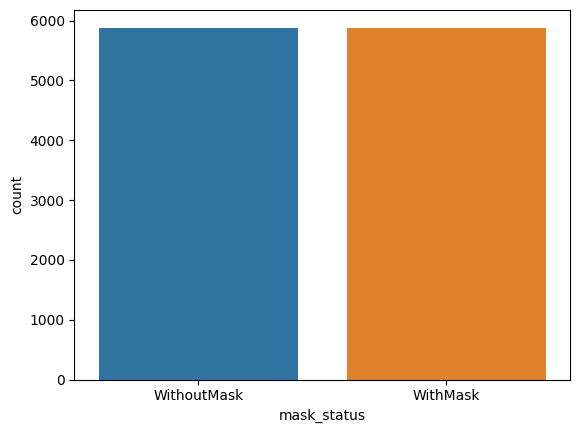

In [18]:
print('With Mask: ', dataset.value_counts('mask_status')[0])
print('Without Mask: ', dataset.value_counts('mask_status')[1])

sns.countplot(x=dataset['mask_status']);

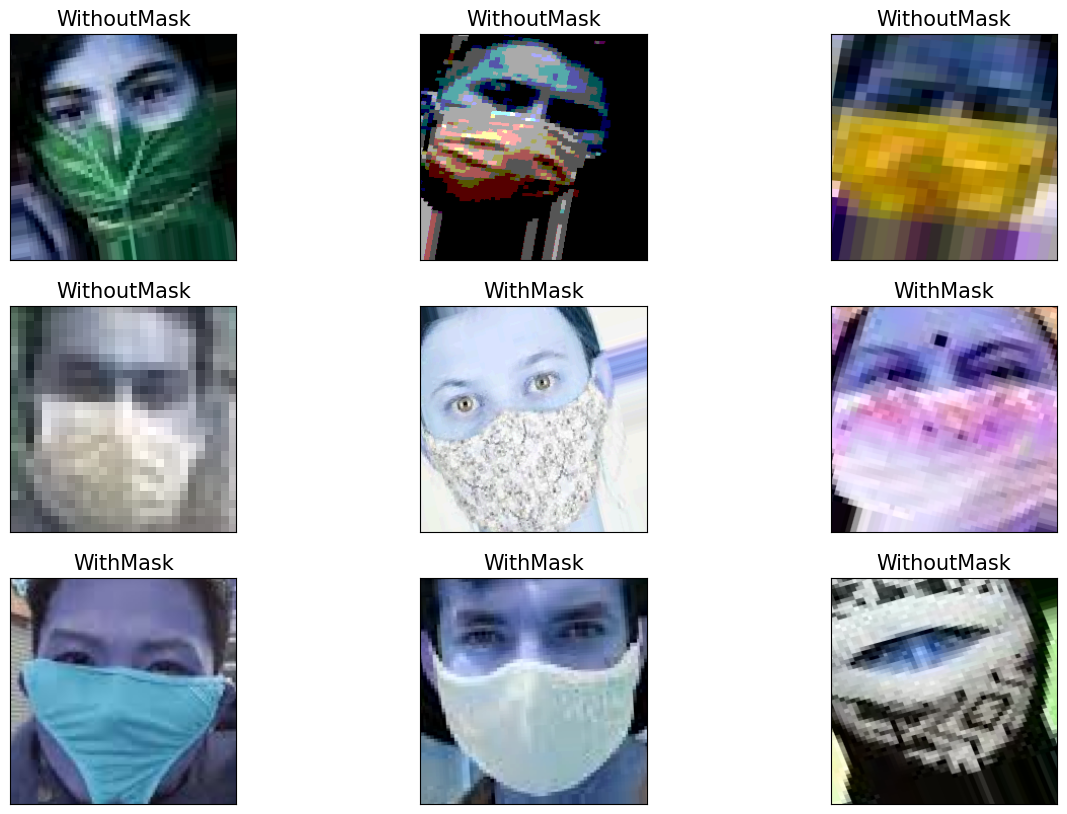

In [22]:
# Randomly select items from dataset and visualize

plt.figure(figsize=(15, 10))
for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3,3, i+1)
    plt.imshow(cv2.imread(dataset.loc[random, 'image_path']))
    plt.title(dataset.loc[random, 'mask_status'], size=15)
    plt.xticks([])
    plt.yticks([])
plt.show()

Interesting.... I suppose panties and leaves are also considsered masks?

In [23]:
train_df = dataset[dataset['where'] == 'Train']
test_df = dataset[dataset['where'] == 'Test']
valid_df = dataset[dataset['where'] == 'Validation']

train_df.head()

,image_path,mask_status,where
966,../data/Face Mask Dataset/Train/WithMask/348.png,WithoutMask,Train
967,../data/Face Mask Dataset/Train/WithMask/Augme...,WithoutMask,Train
968,../data/Face Mask Dataset/Train/WithMask/Augme...,WithoutMask,Train
969,../data/Face Mask Dataset/Train/WithMask/1810.png,WithoutMask,Train
970,../data/Face Mask Dataset/Train/WithMask/Augme...,WithoutMask,Train


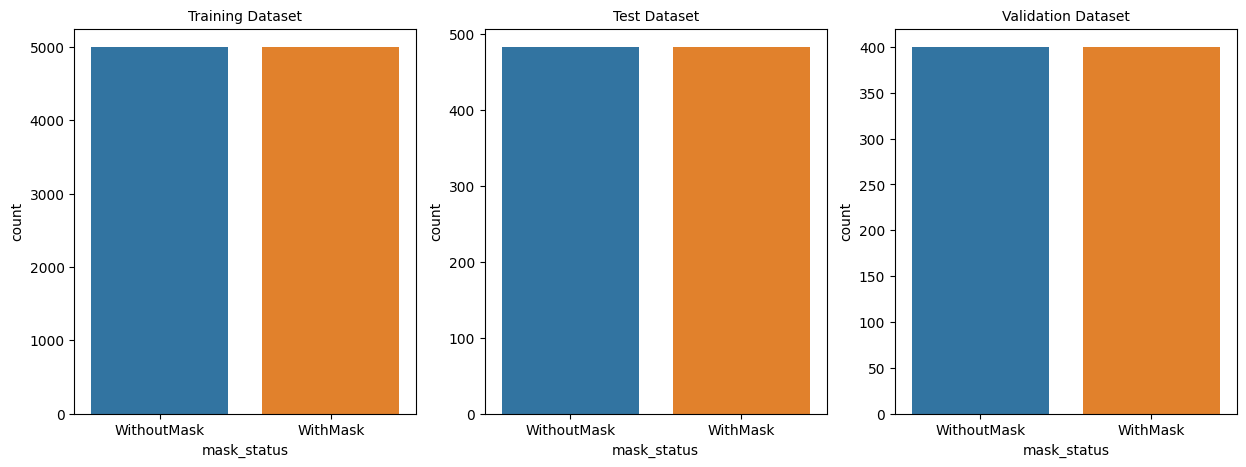

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.countplot(x=train_df['mask_status'])
plt.title('Training Dataset', size=10)

plt.subplot(1,3,2)
sns.countplot(x=test_df['mask_status'])
plt.title('Test Dataset', size=10)

plt.subplot(1,3,3)
sns.countplot(x=valid_df['mask_status'])
plt.title('Validation Dataset', size=10)

plt.show()

### Preprocessing (Training Dataset)

In [28]:
train_df = train_df.reset_index(drop=True)
train_df.head()

,image_path,mask_status,where
0,../data/Face Mask Dataset/Train/WithMask/348.png,WithoutMask,Train
1,../data/Face Mask Dataset/Train/WithMask/Augme...,WithoutMask,Train
2,../data/Face Mask Dataset/Train/WithMask/Augme...,WithoutMask,Train
3,../data/Face Mask Dataset/Train/WithMask/1810.png,WithoutMask,Train
4,../data/Face Mask Dataset/Train/WithMask/Augme...,WithoutMask,Train


In [29]:
data = []
image_size = 150

for i in range(len(train_df)):
    
    # Convert image to grayscale
    img_array = cv2.imread(train_df['image_path'][i], cv2.IMREAD_GRAYSCALE)

    # Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    # Encoding image with label
    if train_df['mask_status'][i] == 'WithMask':
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [30]:
data[0]

[array([[141, 146, 164, ...,  91,  93,  93],
        [142, 147, 163, ...,  92,  94,  94],
        [143, 146, 158, ...,  94,  95,  95],
        ...,
        [160, 163, 175, ...,  80,  73,  71],
        [172, 174, 180, ...,  87,  82,  80],
        [175, 177, 181, ...,  89,  84,  82]], dtype=uint8),
 0]

In [32]:
np.random.shuffle(data)

In [33]:
data[0]

[array([[134, 134, 134, ...,  32,  32,  32],
        [134, 134, 134, ...,  32,  32,  32],
        [134, 134, 134, ...,  32,  32,  32],
        ...,
        [110,  86,  66, ...,  72,  68,  68],
        [110,  78,  70, ...,  85,  84,  83],
        [108,  75,  75, ...,  99,  97,  96]], dtype=uint8),
 0]

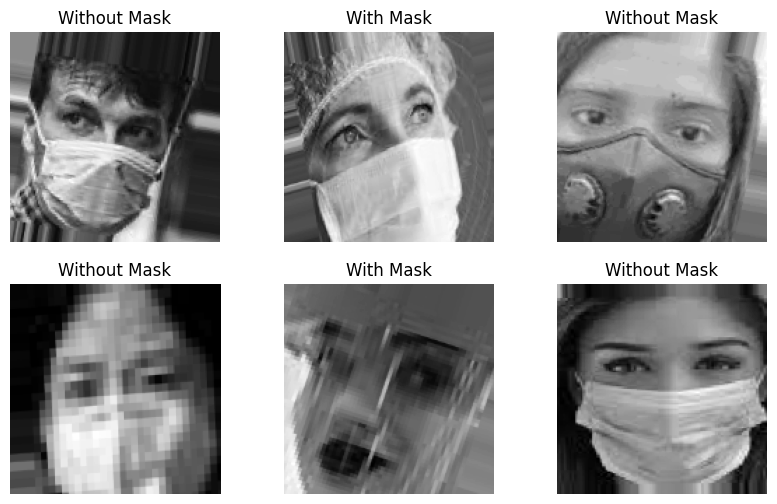

In [36]:
fig, ax = plt.subplots(2, 3, figsize=(10,6))

for row in range(2):
    for col in range(3):
        image_index = row * 100 + col

        ax[row, col].axis('off')
        ax[row, col].imshow(data[image_index][0], cmap='gray')

        if data[image_index][1] == 0:
            ax[row, col].set_title('Without Mask')
        else:
            ax[row, col].set_title('With Mask')

In [37]:
X = []
y = []

for image in data:
    X.append(image[0])
    y.append(image[1])

X = np.array(X)
y = np.array(y)

### Modeling

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

In [48]:
model = models.Sequential(
    [
        layers.Conv2D(
            32, kernel_size=(5,5), strides=(1,1), padding='same',
            activation='relu', input_shape=(150,150,1)),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        layers.Conv2D(64, (2,2), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1000, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

In [49]:
model.compile(
    optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [53]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
250/250 [==============================] - 59s 235ms/step - loss: 0.6942 - accuracy: 0.5013
Epoch 2/10
250/250 [==============================] - 60s 239ms/step - loss: 0.6936 - accuracy: 0.5027
Epoch 3/10
250/250 [==============================] - 59s 235ms/step - loss: 0.6933 - accuracy: 0.5067
Epoch 4/10
250/250 [==============================] - 57s 229ms/step - loss: 0.6927 - accuracy: 0.5063
Epoch 5/10
250/250 [==============================] - 57s 229ms/step - loss: 0.6918 - accuracy: 0.5030
Epoch 6/10
250/250 [==============================] - 57s 229ms/step - loss: 0.6919 - accuracy: 0.5050
Epoch 7/10
250/250 [==============================] - 57s 228ms/step - loss: 0.6912 - accuracy: 0.5054
Epoch 8/10
250/250 [==============================] - 57s 227ms/step - loss: 0.6912 - accuracy: 0.5121
Epoch 9/10
250/250 [==============================] - 57s 228ms/step - loss: 0.6886 - accuracy: 0.5178
Epoch 10/10
250/250 [==============================] - 57s 228ms/step - l

FYI: Training was run on local CPU.

In [54]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 4s 61ms/step - loss: 0.7472 - accuracy: 0.3380


[0.7472004890441895, 0.33799999952316284]

In [55]:
prediction = (model.predict(X_val) > 0.5).astype('int32')

print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

63/63 [==============================] - 4s 61ms/step
              precision    recall  f1-score   support

           0       0.39      0.60      0.48      1004
           1       0.16      0.08      0.10       996

    accuracy                           0.34      2000
   macro avg       0.28      0.34      0.29      2000
weighted avg       0.28      0.34      0.29      2000

[[601 403]
 [921  75]]


In [56]:
wrong_result = []

for n in range(0, len(y_val)):
    if prediction[n] != y_val[n]:
        wrong_result.append(n)

len(wrong_result)

1324

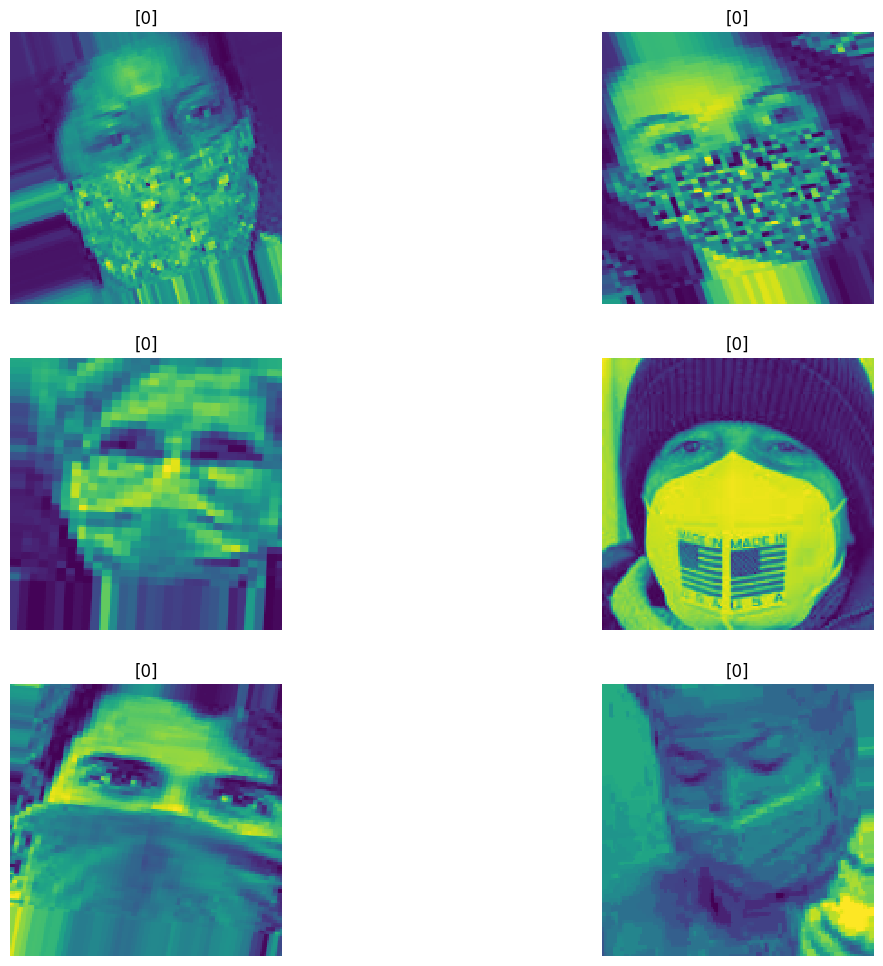

In [57]:
samples = random.choices(population=wrong_result, k=6)

plt.figure(figsize=(14,12))

for idx, n in enumerate(samples):
    plt.subplot(3,2, idx+1)
    plt.imshow(X_val[n].reshape(150,150), interpolation='nearest')
    plt.title(prediction[n])
    plt.axis('off')

plt.show()